# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_residual_stride_deep_vae'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = self.shortcut(x) if self.shortcut is not None else x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        return x

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size

        # Encoder
        self.encoder = nn.Sequential(
            ResidualBlock(3, 32, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 32),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 32),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 64, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 64),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 64),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 128, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 128),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 128),
            nn.Dropout(dropout_rate)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, embedding_size) # mean
        self.fc2 = nn.Linear(8 * 8 * 128, embedding_size) # logvar

        # Decoder
        self.fc3 = nn.Linear(embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            ResidualBlock(128, 128),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 64),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 32),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 32),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        mean = self.fc1(x)
        logvar = self.fc1(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(device)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std
    
    def decode(self, x):
        x = self.fc3(x)  # Reshape back to 8x8x128
        x = x.view(x.size(0), 128, 8, 8)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x = self.decode(z)
        return x, mean, logvar
    
class AutoencoderWrapper(nn.Module):
    def __init__(self, model):
        super(AutoencoderWrapper, self).__init__()
        self.model = model 
    
    def forward(self, x):
        x, mean, logvar = self.model(x)
        return x, mean

In [3]:
from util import calc_and_plot_metrics, train_vae_model_steps, plot_model, count_parameters, save_to_file, load_from_file

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=50):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_vae_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    model = AutoencoderWrapper(model)
    calc_and_plot_metrics(model, testset)
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 1716267
Epoch [1/50], Train Loss: 57950.8608, Test Loss: 47205.4768
Epoch [2/50], Train Loss: 37427.9913, Test Loss: 32273.7263
Epoch [3/50], Train Loss: 31295.1102, Test Loss: 32067.8443
Epoch [4/50], Train Loss: 30095.1951, Test Loss: 29586.8721
Epoch [5/50], Train Loss: 29177.0252, Test Loss: 30381.2462
Epoch [6/50], Train Loss: 28615.2500, Test Loss: 28787.0275
Epoch [7/50], Train Loss: 27938.3099, Test Loss: 27986.3697
Epoch [8/50], Train Loss: 27429.7193, Test Loss: 27425.0874
Epoch [9/50], Train Loss: 26858.6787, Test Loss: 27012.3579
Epoch [10/50], Train Loss: 26365.7628, Test Loss: 26989.7878
Epoch [11/50], Train Loss: 25926.1528, Test Loss: 25393.6266
Epoch [12/50], Train Loss: 25737.2590, Test Loss: 25498.3065
Epoch [13/50], Train Loss: 25345.2944, Test Loss: 25264.4160
Epoch [14/50], Train Loss: 25102.0736, Test Loss: 26071.3912
Epoch [15/50], Train Loss: 24964.5286, Test Loss: 24626.2824
Epoch [16/50], Train Loss: 24867.2360, Test Loss: 25143.0432
Epo

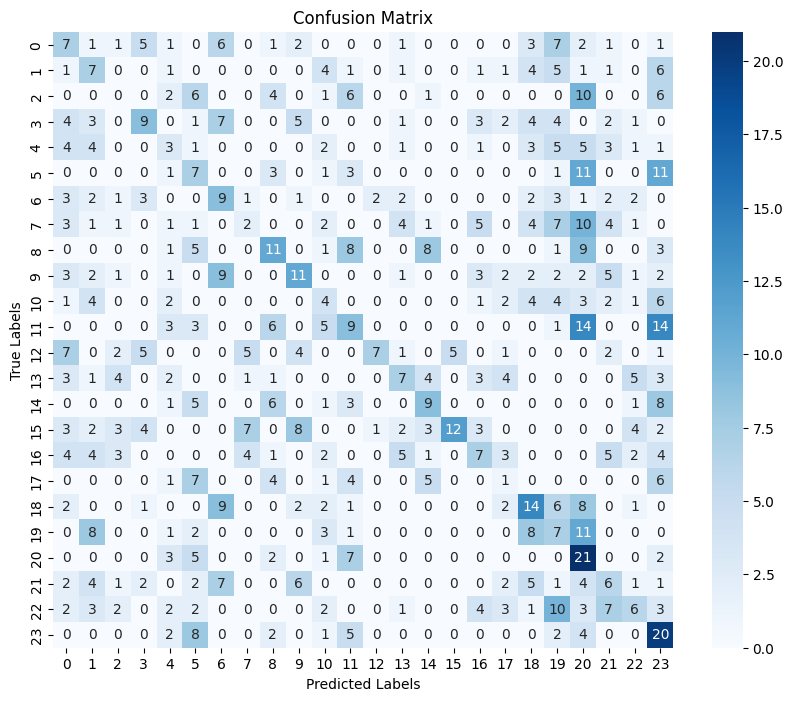

Silhouette Score: -0.09948713332414627
Cluster Purity: 0.231
Normalized Mutual Information (NMI): 0.07954923474640399


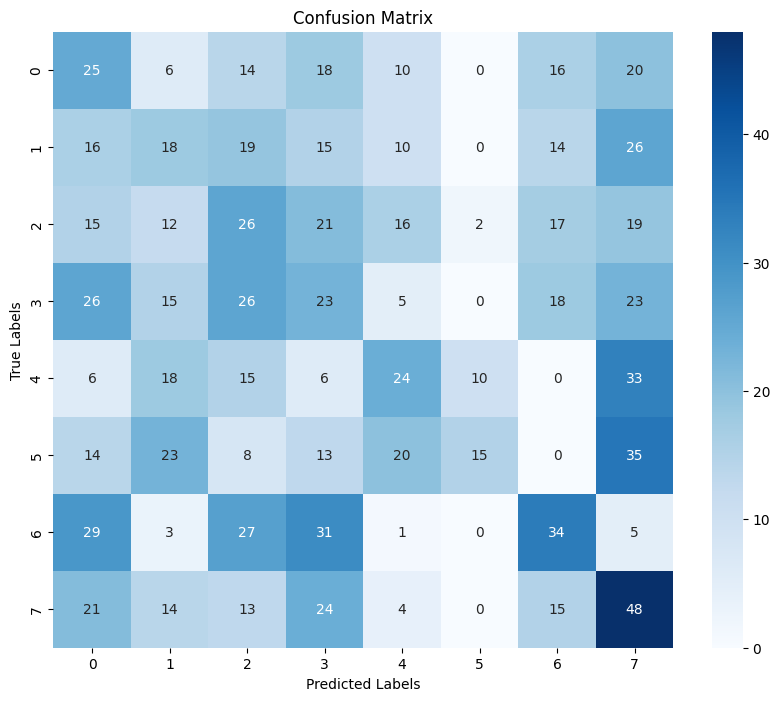

Silhouette Score: 0.0415174663066864
Cluster Purity: 0.476
Normalized Mutual Information (NMI): 0.12516469536379063


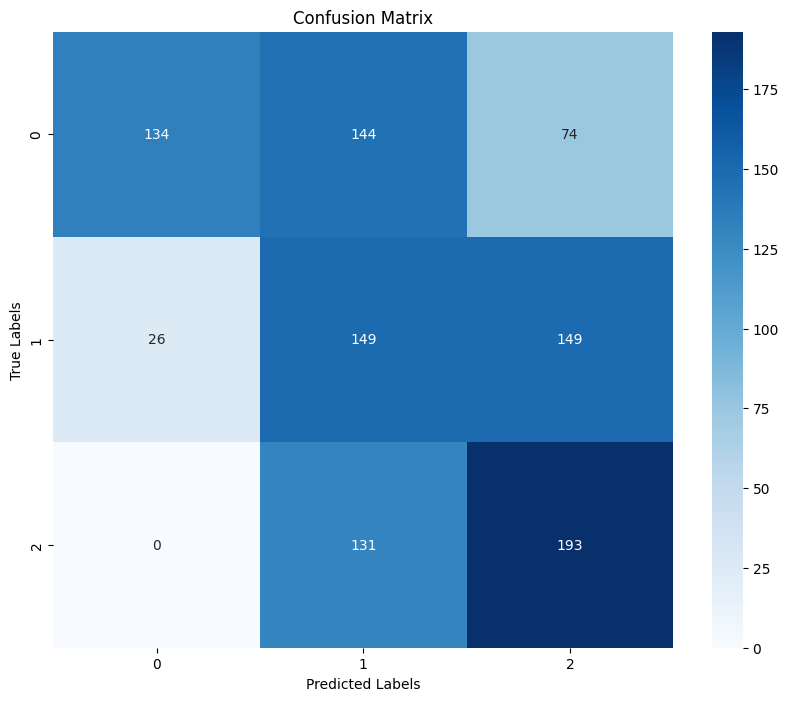

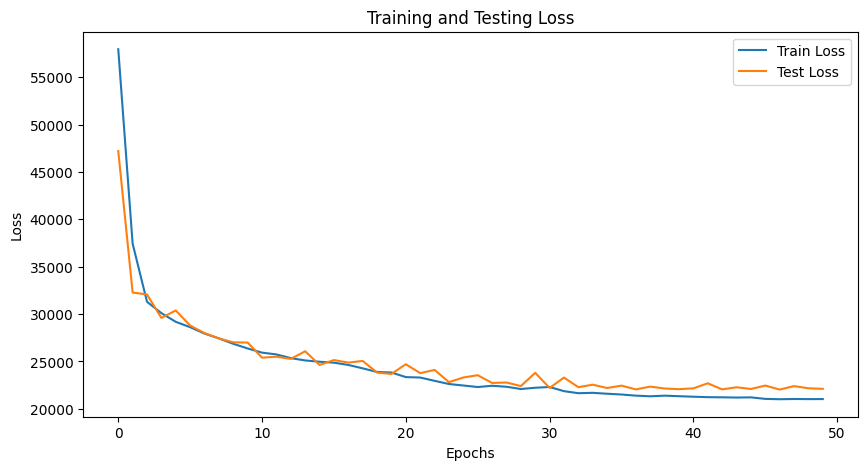

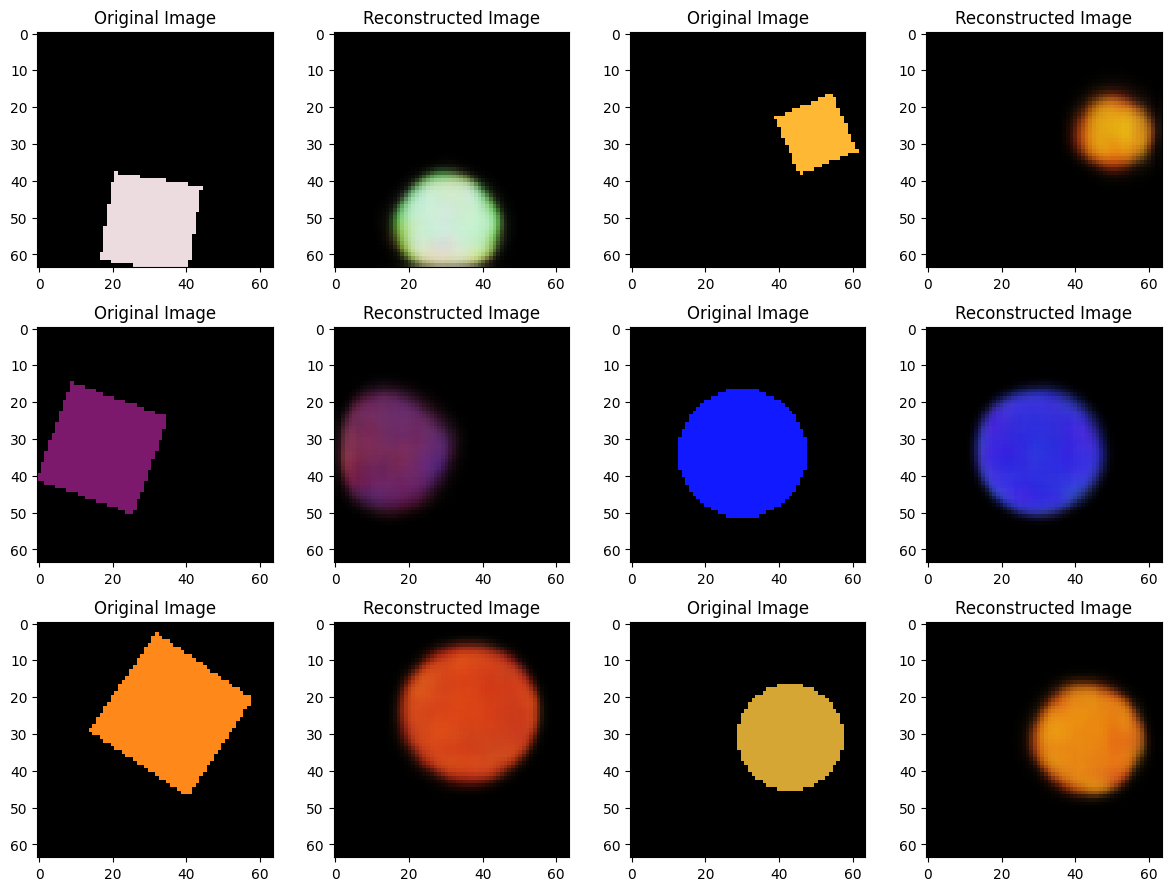

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 1814579
Epoch [1/50], Train Loss: 46628.9641, Test Loss: 32005.8638
Epoch [2/50], Train Loss: 31191.6446, Test Loss: 31410.3393
Epoch [3/50], Train Loss: 29363.4116, Test Loss: 27936.0300
Epoch [4/50], Train Loss: 26873.9113, Test Loss: 25810.3442
Epoch [5/50], Train Loss: 25484.0499, Test Loss: 24852.2215
Epoch [6/50], Train Loss: 24671.8105, Test Loss: 24262.6537
Epoch [7/50], Train Loss: 24034.1310, Test Loss: 24713.5376
Epoch [8/50], Train Loss: 23679.3687, Test Loss: 24635.2686
Epoch [9/50], Train Loss: 22953.8223, Test Loss: 23215.7707
Epoch [10/50], Train Loss: 22626.3501, Test Loss: 22625.2051
Epoch [11/50], Train Loss: 22155.8901, Test Loss: 21948.4434
Epoch [12/50], Train Loss: 21844.3929, Test Loss: 22382.2829
Epoch [13/50], Train Loss: 21505.1594, Test Loss: 21594.0697
Epoch [14/50], Train Loss: 21178.9827, Test Loss: 22227.6503
Epoch [15/50], Train Loss: 21002.1310, Test Loss: 21117.5778
Epoch [16/50], Train Loss: 20776.8624, Test Loss: 20597.3208
Epo

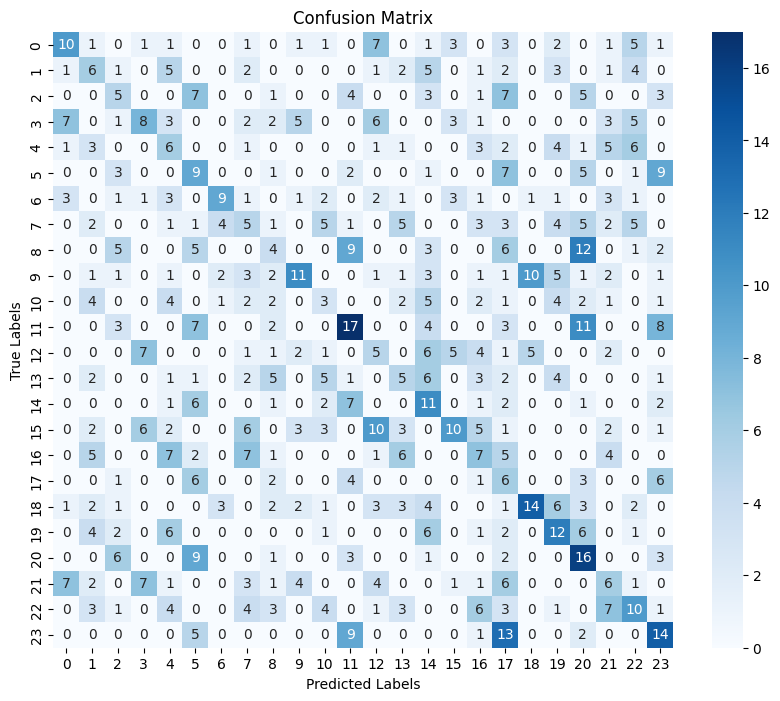

Silhouette Score: -0.052217911928892136
Cluster Purity: 0.219
Normalized Mutual Information (NMI): 0.053475001766232926


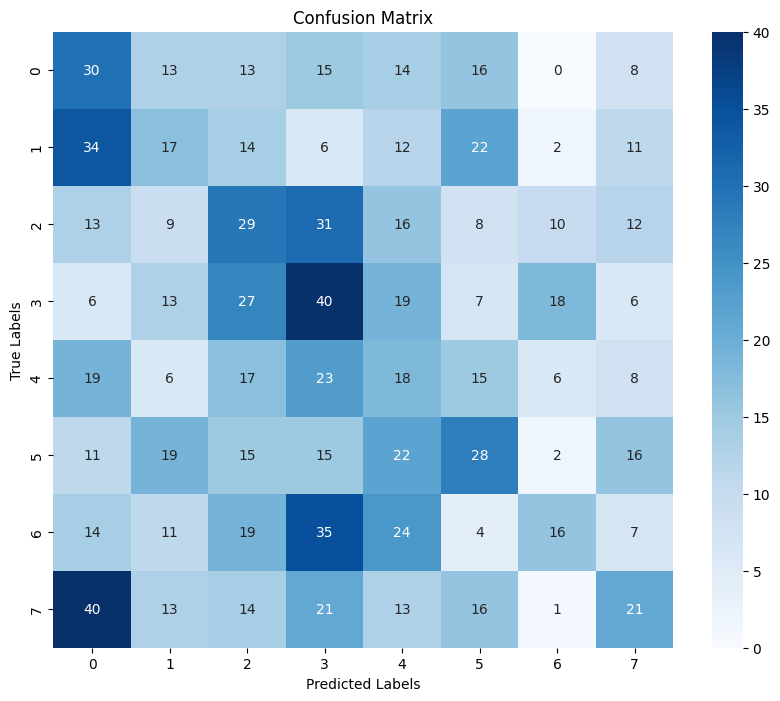

Silhouette Score: 0.051564086228609085
Cluster Purity: 0.546
Normalized Mutual Information (NMI): 0.22200395164983383


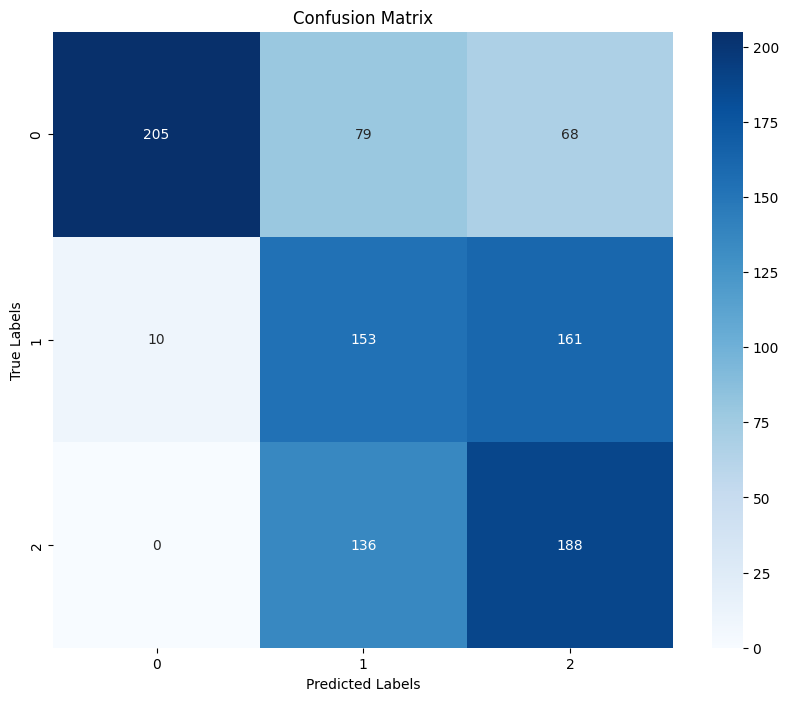

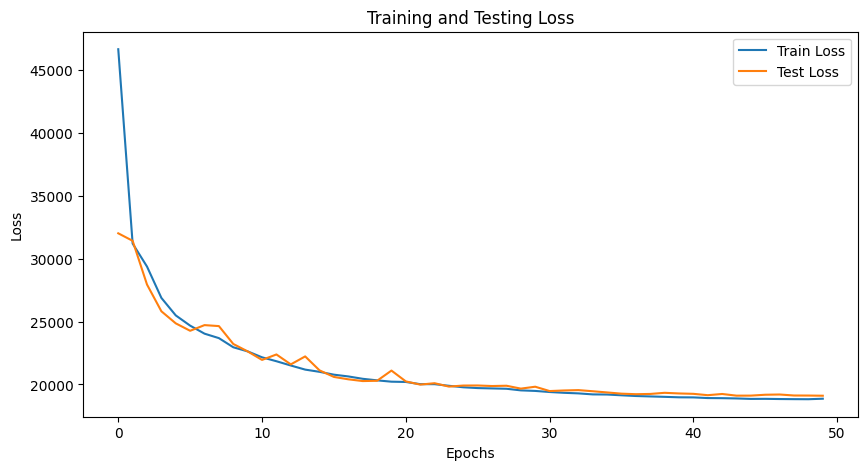

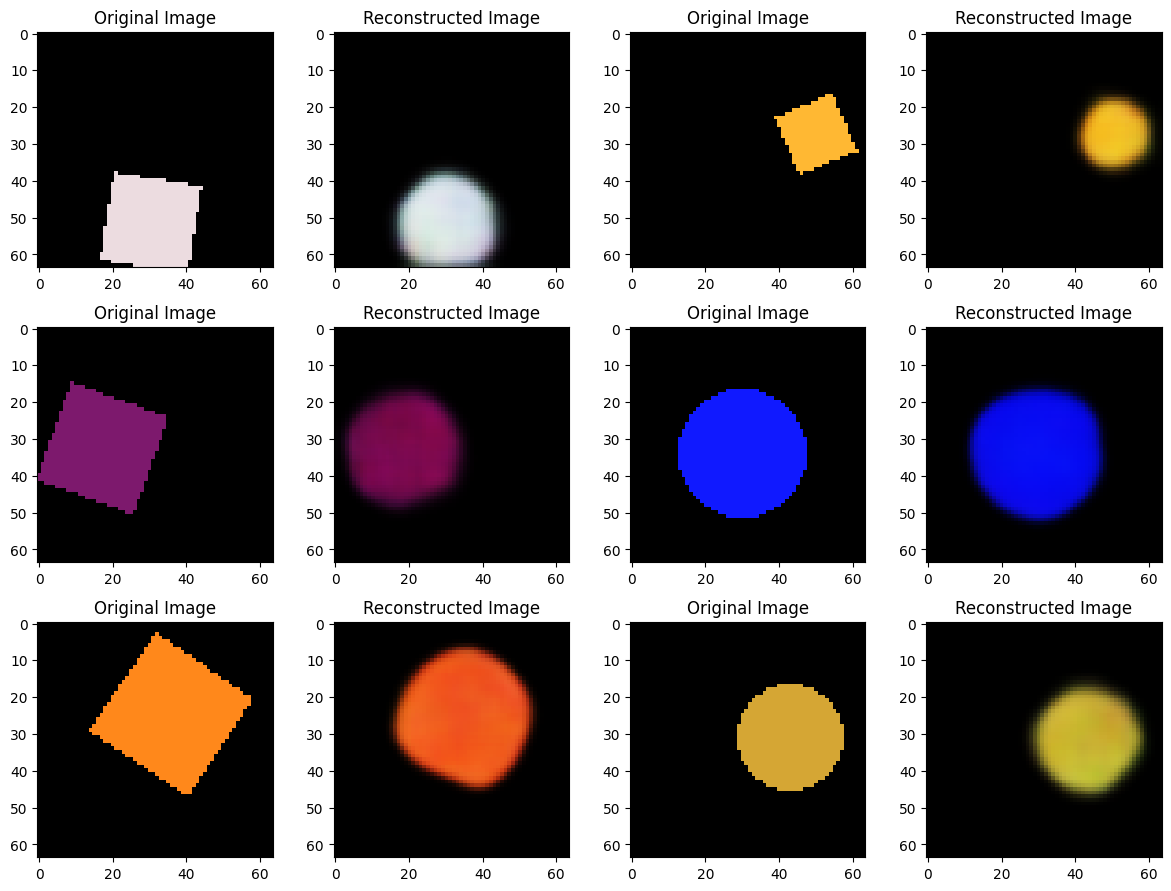

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 2011203
Epoch [1/50], Train Loss: 46320.2249, Test Loss: 32032.8245
Epoch [2/50], Train Loss: 30653.8597, Test Loss: 30213.1013
Epoch [3/50], Train Loss: 28102.5158, Test Loss: 26247.6808
Epoch [4/50], Train Loss: 25938.2288, Test Loss: 25413.3448
Epoch [5/50], Train Loss: 24808.6002, Test Loss: 24298.8187
Epoch [6/50], Train Loss: 23626.9827, Test Loss: 23742.9104
Epoch [7/50], Train Loss: 22741.3709, Test Loss: 23238.7535
Epoch [8/50], Train Loss: 22141.1850, Test Loss: 22648.0669
Epoch [9/50], Train Loss: 21649.2366, Test Loss: 21524.7750
Epoch [10/50], Train Loss: 21193.6143, Test Loss: 20926.7873
Epoch [11/50], Train Loss: 20934.5061, Test Loss: 21645.5875
Epoch [12/50], Train Loss: 20725.2456, Test Loss: 20502.2209
Epoch [13/50], Train Loss: 20564.6933, Test Loss: 20519.2677
Epoch [14/50], Train Loss: 20319.5170, Test Loss: 20316.1305
Epoch [15/50], Train Loss: 20173.6351, Test Loss: 20454.4241
Epoch [16/50], Train Loss: 20040.4267, Test Loss: 19889.3364
Epo

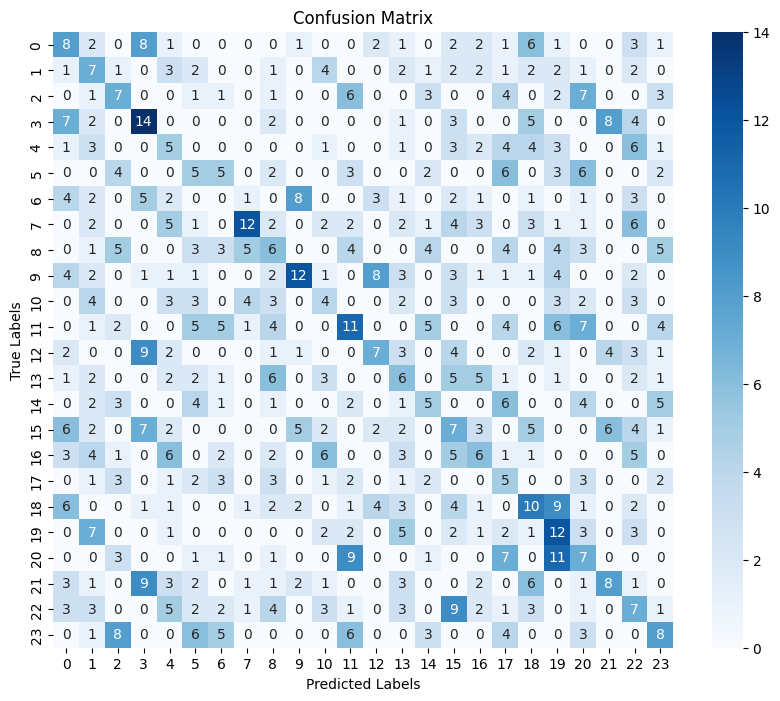

Silhouette Score: -0.05172906443476677
Cluster Purity: 0.177
Normalized Mutual Information (NMI): 0.015707728874420623


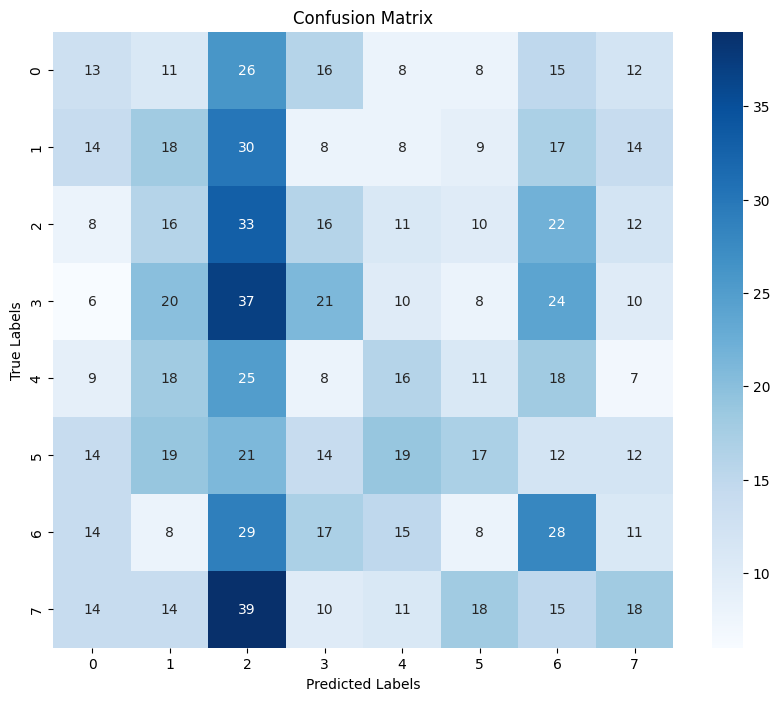

Silhouette Score: 0.051933277398347855
Cluster Purity: 0.595
Normalized Mutual Information (NMI): 0.23482999652008507


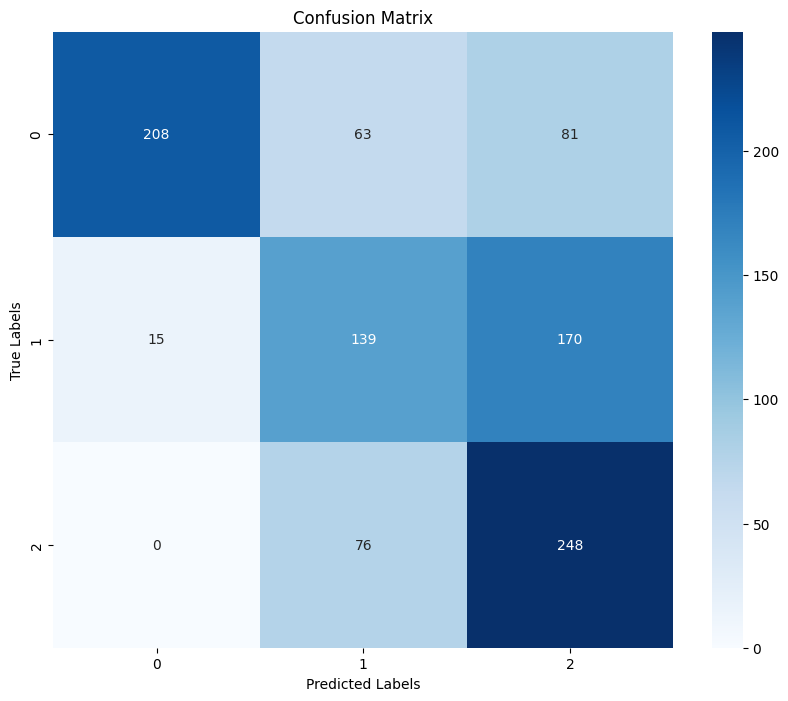

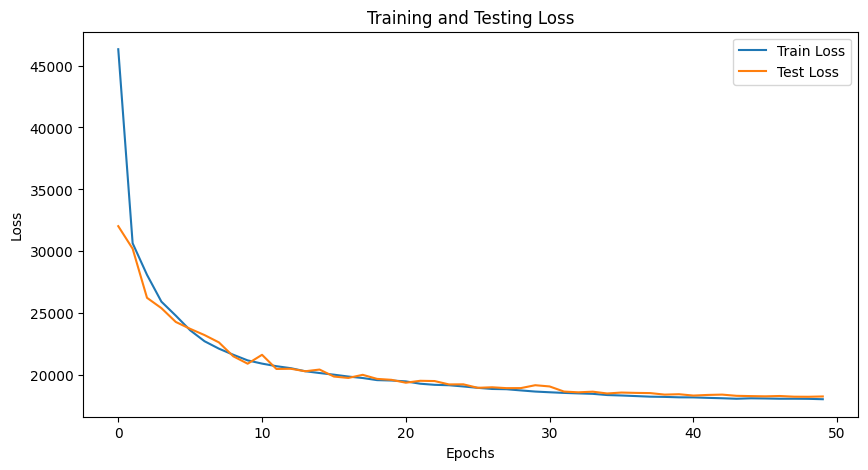

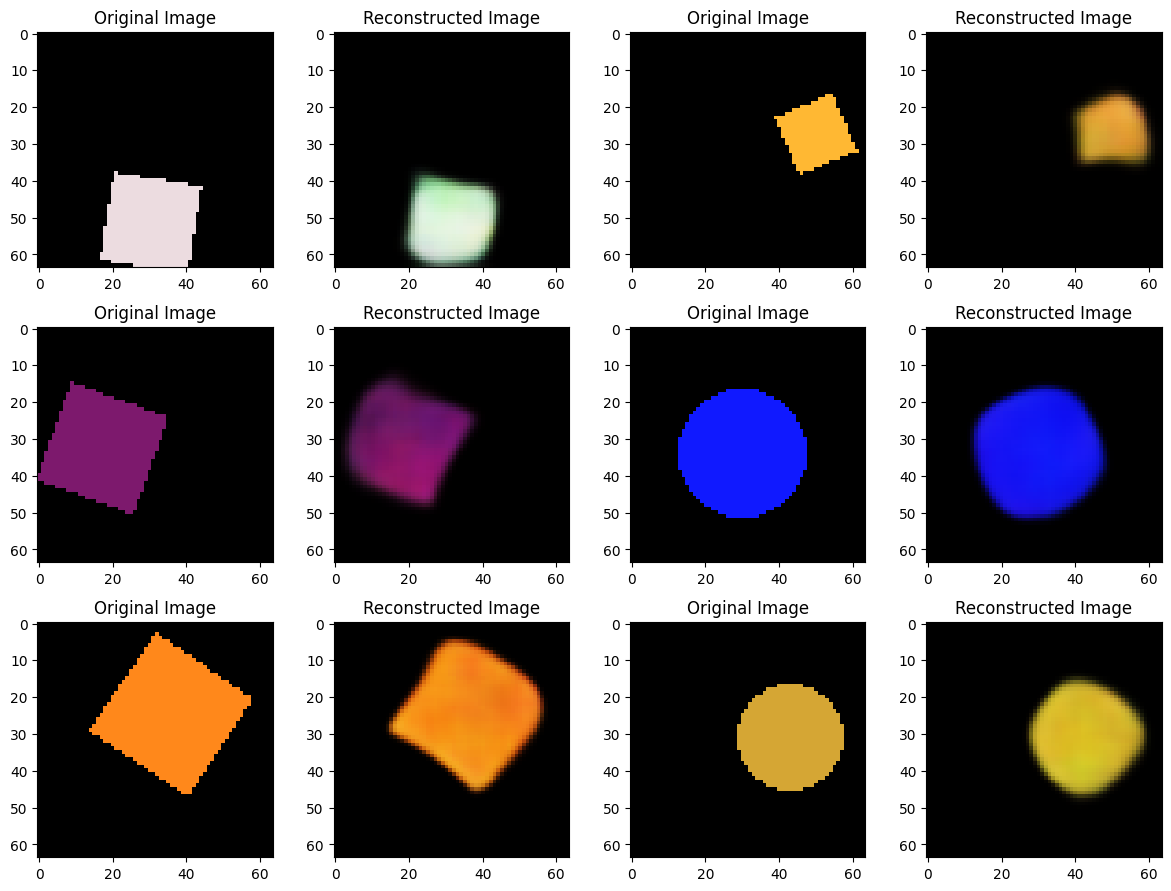

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 2404451
Epoch [1/50], Train Loss: 46591.9613, Test Loss: 33517.7180
Epoch [2/50], Train Loss: 30599.3645, Test Loss: 29374.5255
Epoch [3/50], Train Loss: 27622.5263, Test Loss: 25553.4720
Epoch [4/50], Train Loss: 25545.3631, Test Loss: 25360.3144
Epoch [5/50], Train Loss: 24396.6243, Test Loss: 23767.7663
Epoch [6/50], Train Loss: 23126.8428, Test Loss: 22978.0760
Epoch [7/50], Train Loss: 22354.5311, Test Loss: 21893.9404
Epoch [8/50], Train Loss: 21852.4661, Test Loss: 21891.3148
Epoch [9/50], Train Loss: 21395.3497, Test Loss: 21173.4610
Epoch [10/50], Train Loss: 20982.9689, Test Loss: 20719.7710
Epoch [11/50], Train Loss: 20806.9960, Test Loss: 20656.9980
Epoch [12/50], Train Loss: 20513.3009, Test Loss: 20235.5408
Epoch [13/50], Train Loss: 20297.5340, Test Loss: 20880.0298
Epoch [14/50], Train Loss: 20154.5084, Test Loss: 20341.4407
Epoch [15/50], Train Loss: 20036.1627, Test Loss: 20337.0973
Epoch [16/50], Train Loss: 19856.2803, Test Loss: 19857.5971
Epo

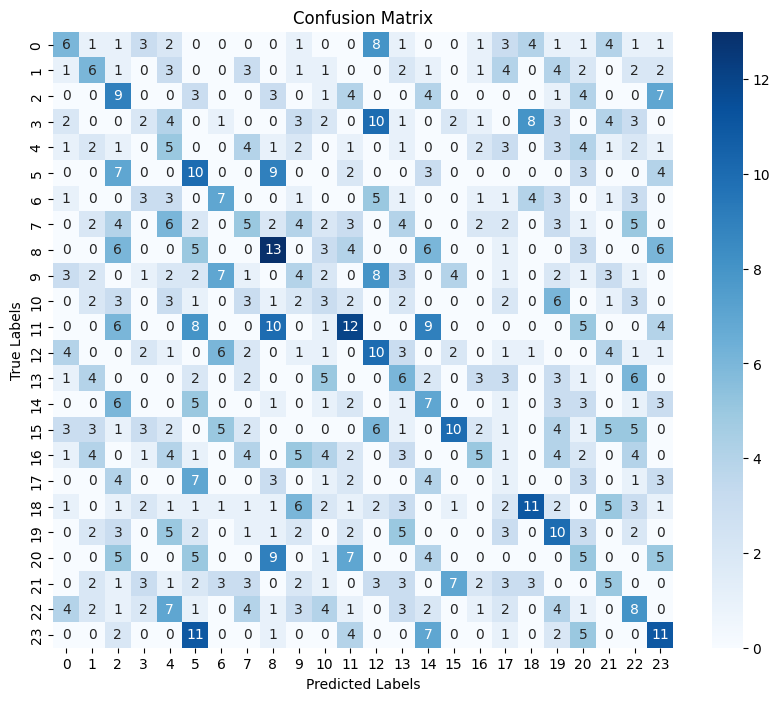

Silhouette Score: -0.058580443263053894
Cluster Purity: 0.18
Normalized Mutual Information (NMI): 0.016270977530573383


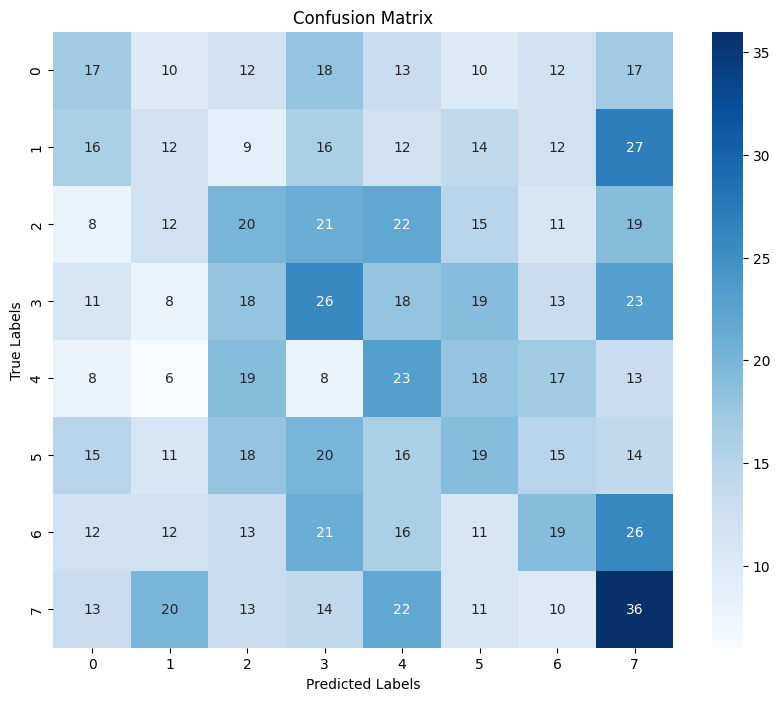

Silhouette Score: 0.04582584649324417
Cluster Purity: 0.555
Normalized Mutual Information (NMI): 0.21445727927759783


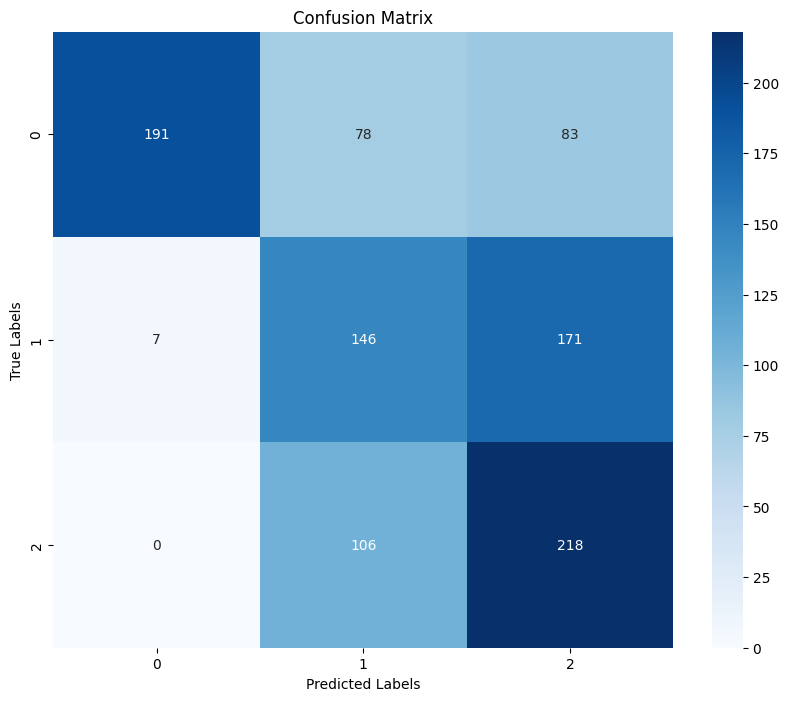

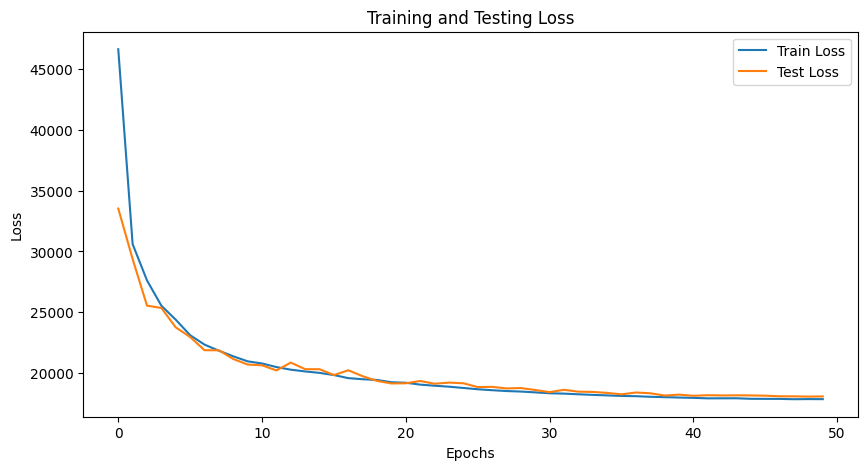

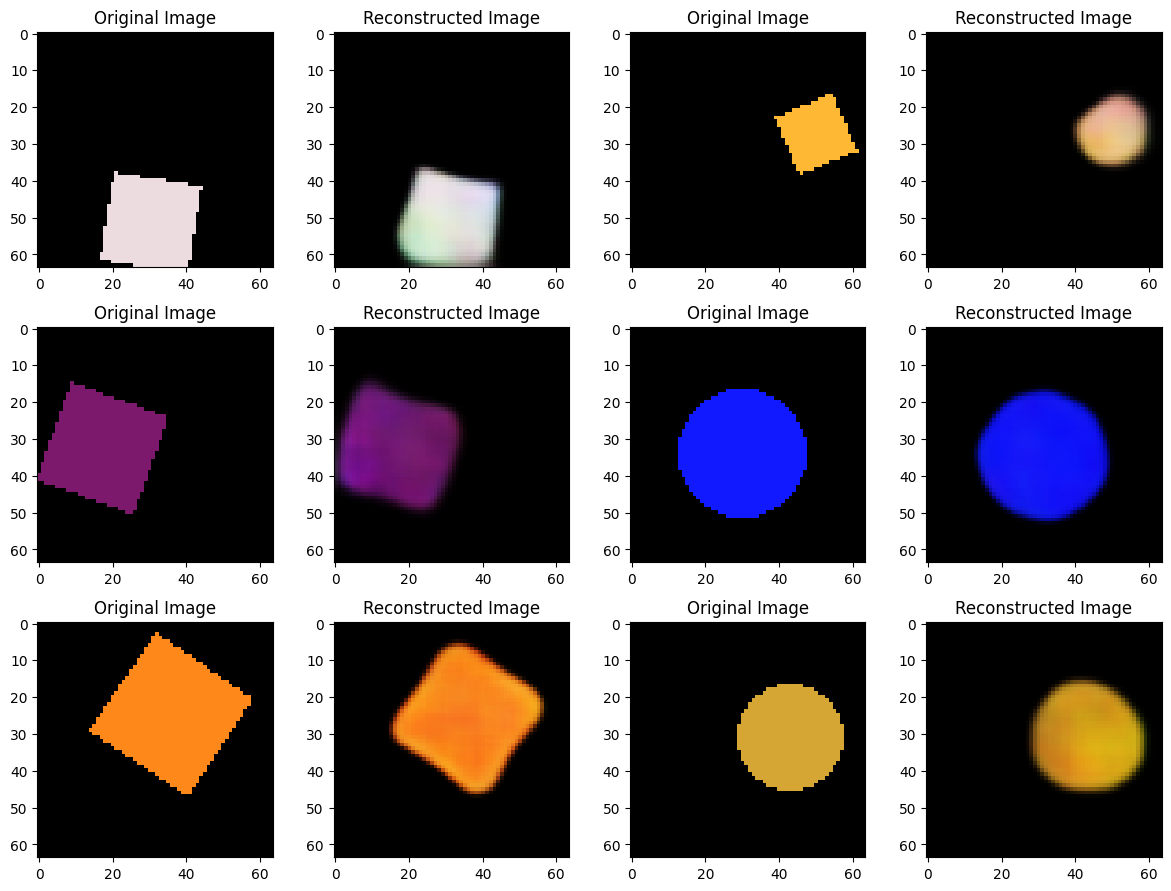

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 3190947
Epoch [1/50], Train Loss: 41901.4396, Test Loss: 31482.5889
Epoch [2/50], Train Loss: 30187.6465, Test Loss: 29424.8932
Epoch [3/50], Train Loss: 26815.4158, Test Loss: 25488.8418
Epoch [4/50], Train Loss: 25234.2171, Test Loss: 24824.7034
Epoch [5/50], Train Loss: 24182.9311, Test Loss: 23690.6290
Epoch [6/50], Train Loss: 22909.3417, Test Loss: 23399.0924
Epoch [7/50], Train Loss: 22040.4673, Test Loss: 21739.1318
Epoch [8/50], Train Loss: 21541.8061, Test Loss: 21687.4249
Epoch [9/50], Train Loss: 21323.8624, Test Loss: 21173.2085
Epoch [10/50], Train Loss: 20920.1941, Test Loss: 21161.8913
Epoch [11/50], Train Loss: 20714.9299, Test Loss: 20718.7767
Epoch [12/50], Train Loss: 20536.9373, Test Loss: 20627.7591
Epoch [13/50], Train Loss: 20246.3039, Test Loss: 20546.9408
Epoch [14/50], Train Loss: 20123.4683, Test Loss: 20371.5032
Epoch [15/50], Train Loss: 19945.2989, Test Loss: 20329.1229
Epoch [16/50], Train Loss: 19811.3607, Test Loss: 20275.3872
Epo

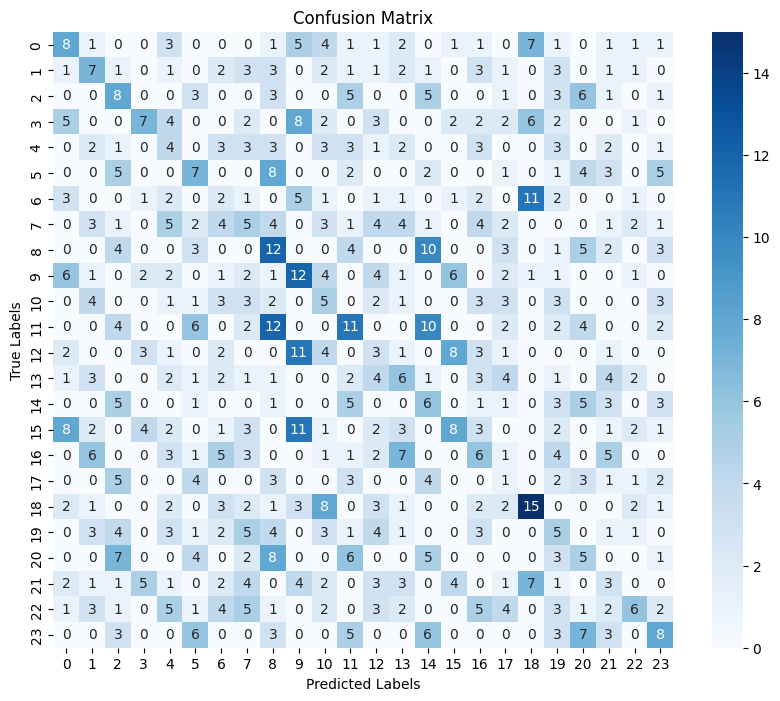

Silhouette Score: -0.05428249388933182
Cluster Purity: 0.182
Normalized Mutual Information (NMI): 0.017709411930614042


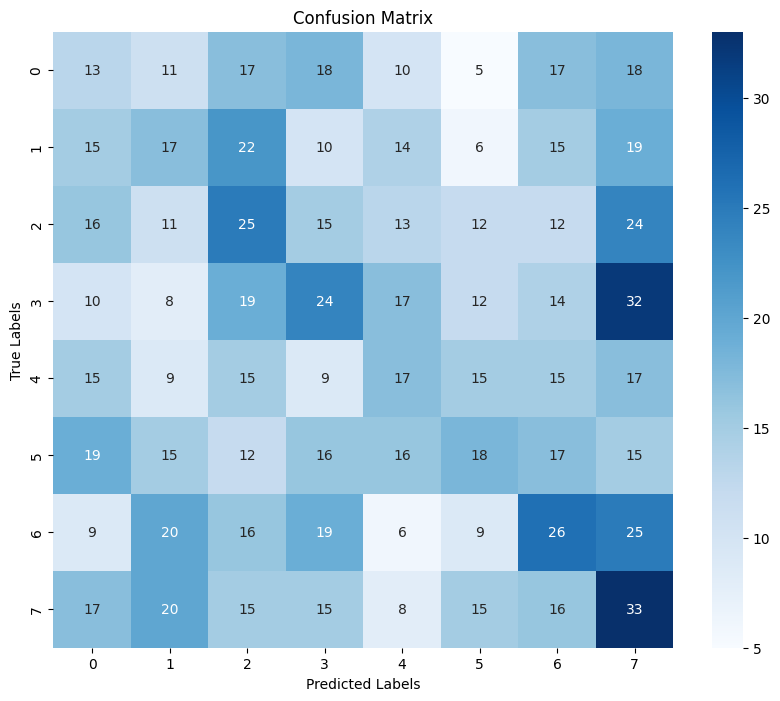

Silhouette Score: 0.03182020038366318
Cluster Purity: 0.526
Normalized Mutual Information (NMI): 0.21422073749624815


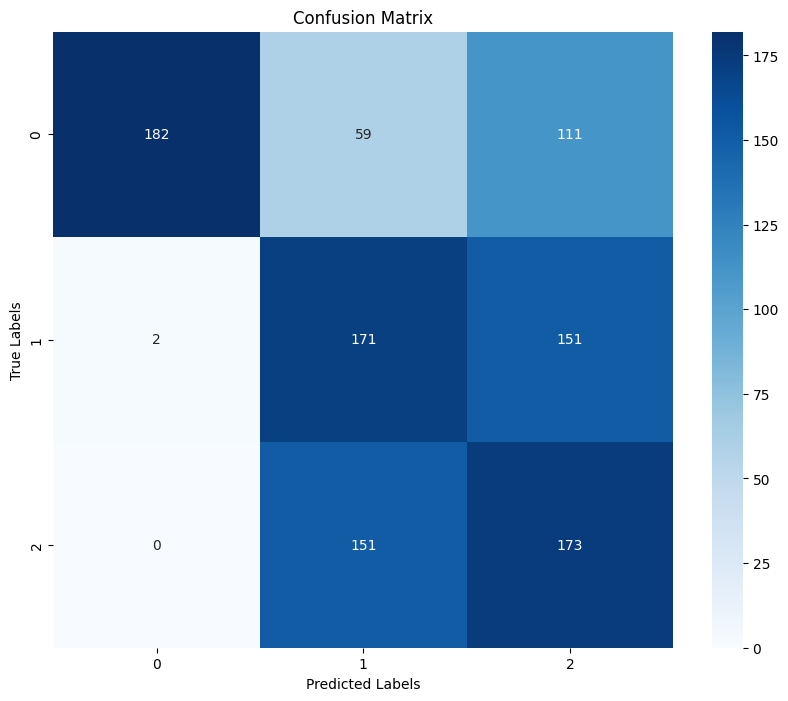

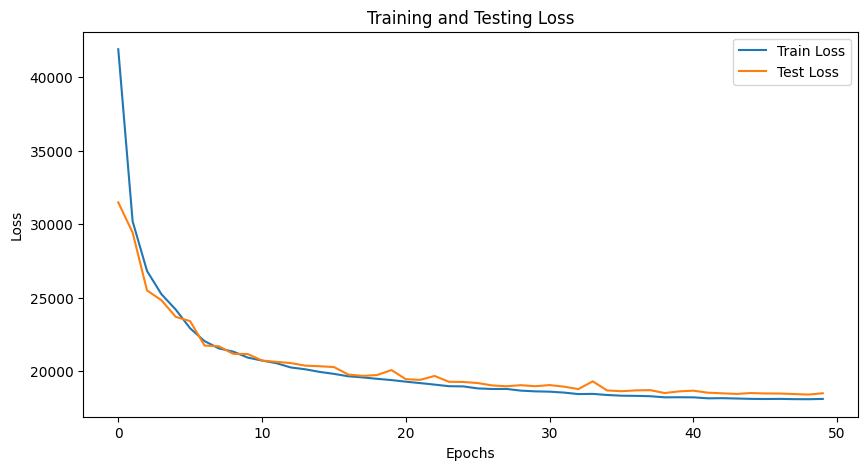

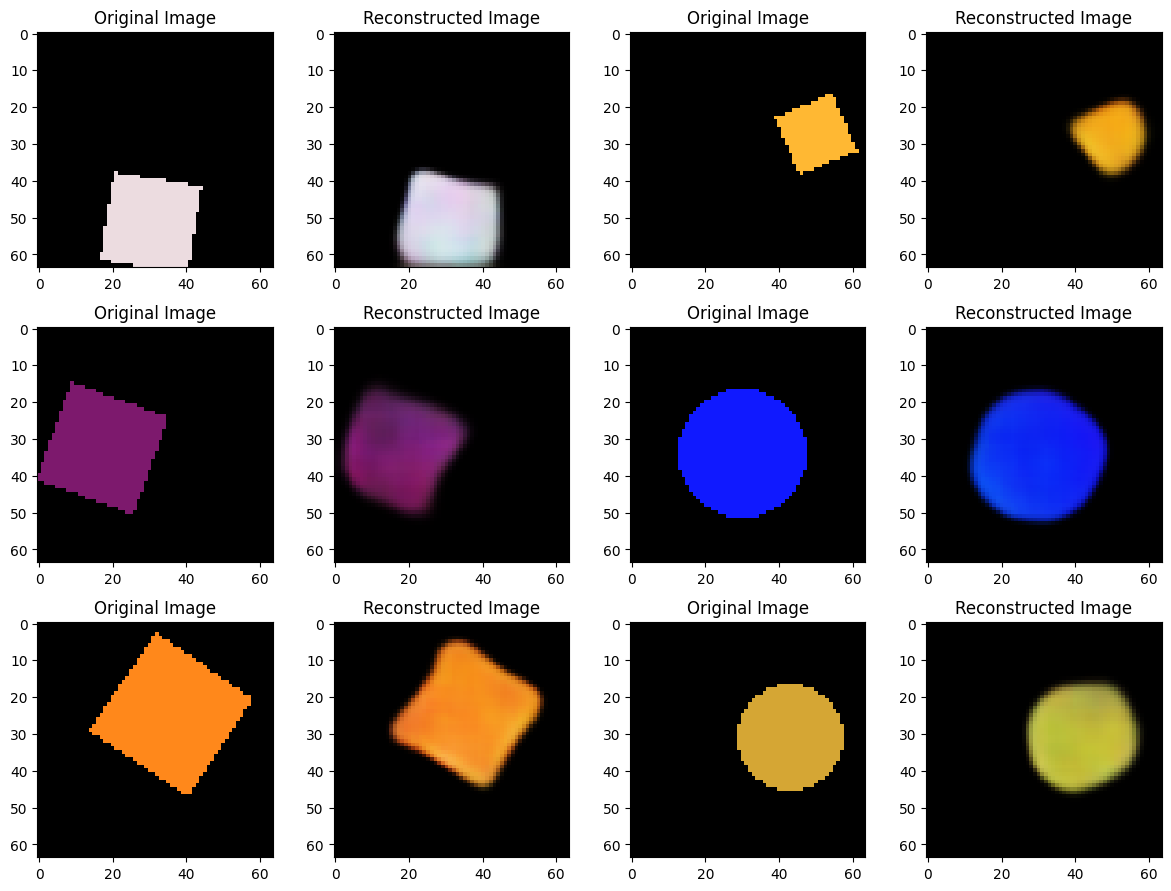

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)